# 1. Binomial coefficient

Number of ways $n$ stochastic events can be arranged: $n(n-1)(n-2)...=n!$

Number of ways $k$ successes out of $n$ events can be arranged: $n(n-1)(n-2)...(n-k+1)=n!/(n-k)!$

Number of ways $k$ successes can be arranged: $k!$

The order of successes does not matter: $\frac{n!}{k!(n-k)!}$

Note that $\sum_{k=0}^n \frac{n!}{k!(n-k)!} = 2^n$, the total number of possible outcomes.

# 2. Evidence

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
plt.rcdefaults()

In [2]:
#Model
#y = mx + b
m = 1.0
b = 0.0
x = np.linspace(-1, 3, 100 , endpoint=True)
y = m * x + b


In [3]:
# a) make mock data with randomness and a fixed (reproducable) seed
np.random.seed(32)
sigma_y = 0.4 # 1.0
Npoints = 10 # 30
x_ = np.linspace(0, 2, Npoints , endpoint=True)
y_ = np.random.normal(size=len(x_)) * sigma_y + m * x_ + b


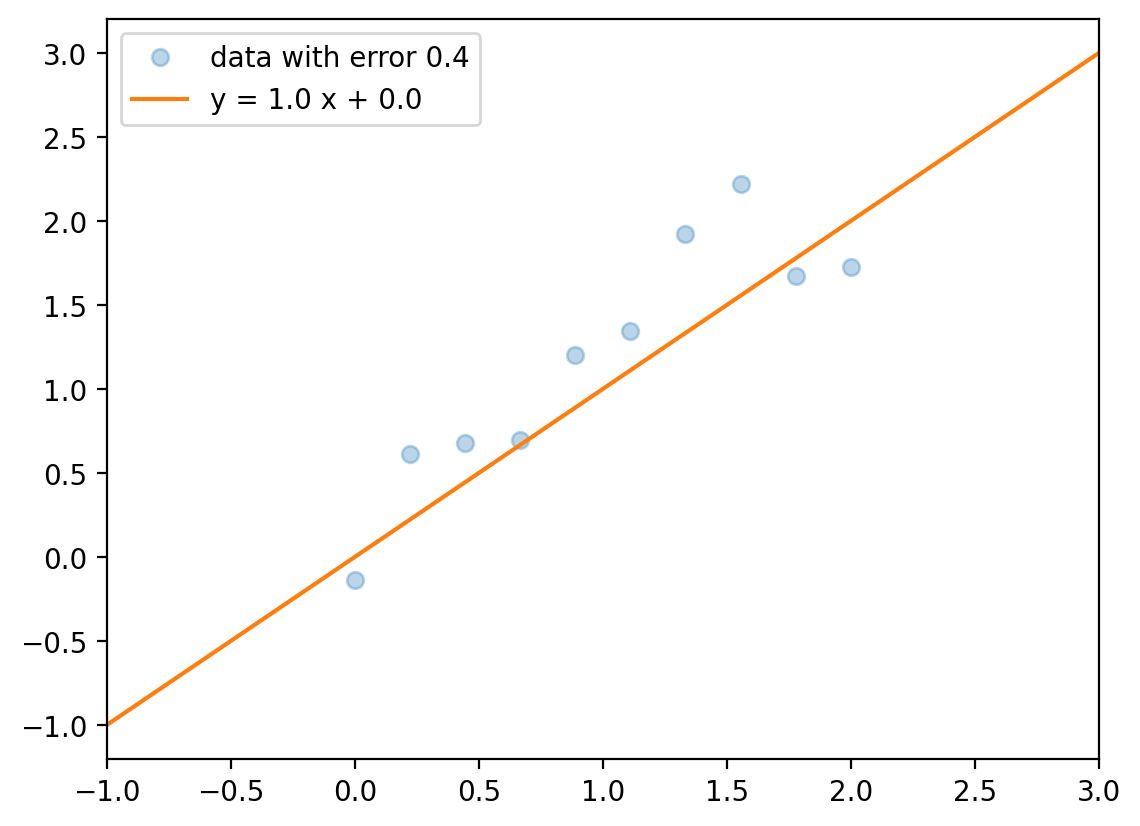

In [4]:
#show data and model
plt.plot(x_, y_, 'o', label='data with error {:}'.format(sigma_y), alpha=0.3)
plt.plot(x, y,  label='y = {:} x + {:}'.format(m,b), linewidth=1.5)
plt.xlim(-1, 3)
plt.legend(loc=2)


In [5]:
# b) helper function to fit a polynomial of any order
def poly(x, coeff):
    y = np.zeros(len(x))
    for i in range(len(coeff)):
        y += coeff[i] * np.power(x, i)
    return y

#predefined parameter ranges.
a_rng = [-4, 4]
m_rng = [-4, 8] 
b_rng = [-2, 2]

#let's first sample a grid differently in each dimension
#so that we are sure we work with axes correctly.
#NsampleBMZ = 95, 100, 105
NsampleBMZ = 100, 100, 100

#get arrays of y = ax^2 + mx + b
barr = np.linspace(b_rng[0], b_rng[1], NsampleBMZ[0], endpoint=True)
marr = np.linspace(m_rng[0], m_rng[1], NsampleBMZ[1], endpoint=True)
aarr = np.linspace(a_rng[0], a_rng[1], NsampleBMZ[2], endpoint=True)

#what are the priors on this params P(\Theta|Model)
PriorA = 1.0 / (a_rng[1] - a_rng[0])
PriorB = 1.0 / (b_rng[1] - b_rng[0])
PriorM = 1.0 / (m_rng[1] - m_rng[0])


In [6]:
#let's calculate the chi^2. 
chi2_b = np.zeros(NsampleBMZ[0])
chi2_bm = np.zeros((NsampleBMZ[0], NsampleBMZ[1]))
chi2_bma = np.zeros((NsampleBMZ[0], NsampleBMZ[1], NsampleBMZ[2]))

#determine each chi^2 = -0.5 * Sum( (data - model)^2 )
for i, b_ in enumerate(barr):
    chi2_b[i] = 0.5 * np.sum( np.power(poly(x_, [b_]) - y_, 2) / sigma_y**2)
    for j, m_ in enumerate(marr):
        chi2_bm[i, j] = 0.5 * np.sum( np.power(poly(x_, [b_, m_]) - y_, 2) / sigma_y**2)
        for k, a_ in enumerate(aarr):
            chi2_bma[i, j, k] = 0.5 * np.sum( np.power(poly(x_, [b_, m_, a_]) - y_, 2) / sigma_y**2)


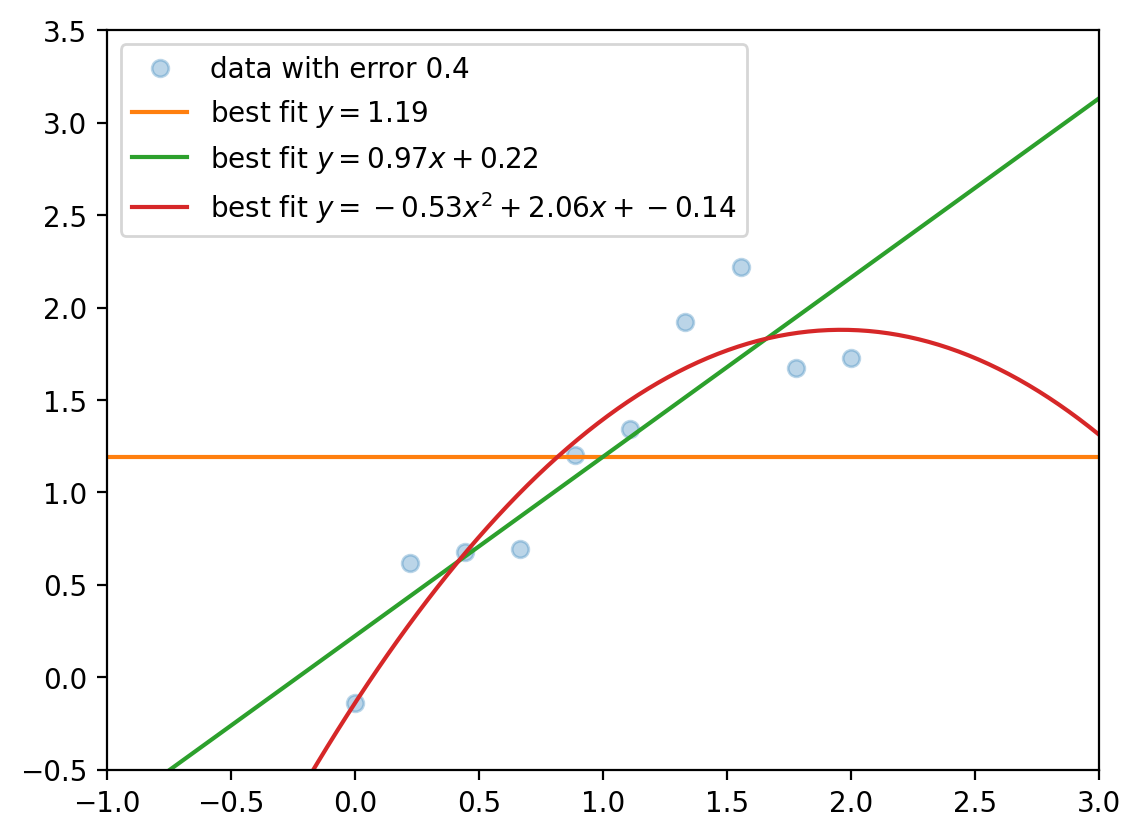

In [7]:
#get min of chi2 [n-d arrray]
min_chi2_b = np.where(chi2_b == np.amin(chi2_b))
min_chi2_bm = np.where(chi2_bm == np.amin(chi2_bm))
min_chi2_bma = np.where(chi2_bma == np.amin(chi2_bma))

#let's plot the lines
plt.plot(x_, y_, 'o', label='data with error {:}'.format(sigma_y), alpha=0.3)

#and get the values for min chi^2
d1 = [barr[min_chi2_b]]
plt.plot(x, poly(x, d1), label='best fit $y = {:0.2f}$'.format(d1[0][0]))

d2 =[barr[min_chi2_bm[0]][0], marr[min_chi2_bm[1]][0]]
plt.plot(x, poly(x, d2), 
         label='best fit $y = {:0.2f}x + {:0.2f}$'.format(d2[1], d2[0]))

d3 = [barr[min_chi2_bma[0]][0], marr[min_chi2_bma[1]][0], aarr[min_chi2_bma[2]][0]]
plt.plot(x, poly(x, d3), 
         label='best fit $y = {:0.2f}x^2 + {:0.2f}x + {:0.2f}$'.format(d3[2], d3[1], d3[0]))

plt.xlim(-1, 3)
plt.ylim(-0.5,3.5)

plt.legend(loc=2)

In [8]:
# c) Calculate the likelihood for each model. like = exp (-Chi^2)
likeb = np.exp(-1.0*chi2_b)
likebm = np.exp(-1.0*chi2_bm)
likebma = np.exp(-1.0*chi2_bma)

In [19]:
#posterior = Likelihood * prior
post_b = (PriorB) * likeb
post_bm = (PriorA * PriorB) * likebm
post_bma = (PriorA * PriorB * PriorM) * likebma

In [20]:
# little helper function to estimate 68\% errors
def sig_err(arr_, bins):
    """starts at peak of arr_, and traverses down both sides of distribution
    until the integral under the region is 0.68
    """
    arr = arr_ / np.trapz(arr_, bins)
    ind = [np.argmax(arr)]
    arr_max = bins[np.argmax(arr_)] # np.average(bins, weights=arr)
    while np.trapz(arr[ind], bins[ind]) < 0.68:
        if np.amin(ind) > 0:
            ind = np.append(np.amin(ind)-1, ind)
        if np.amax(ind) < len(arr)-1:
            ind = np.append(ind, np.amax(ind) +1)
    #returns best fit, -1sigma error, +1sigma error
    return arr_max, arr_max - bins[ind[0]], bins[ind[-1]] - arr_max


(100,)


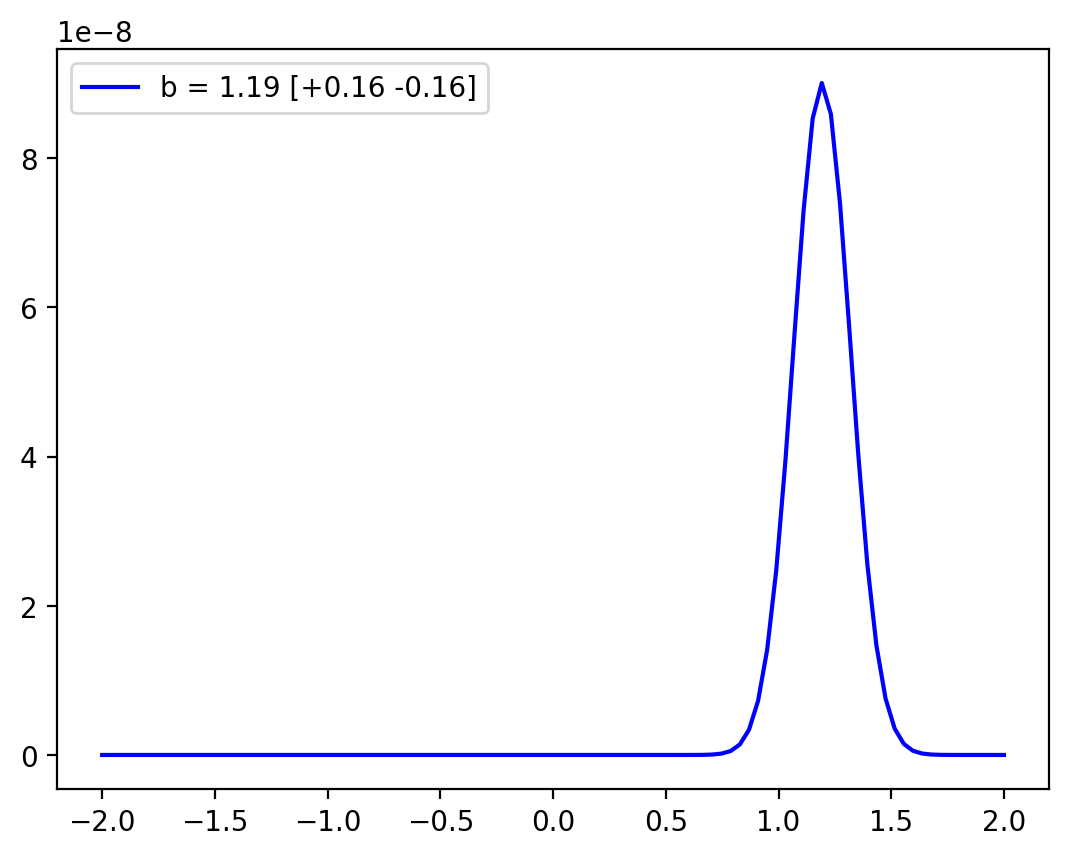

In [21]:
#marginalized constraints 1d case y=b
#marginalize over other params
print(np.shape(post_b))
bm = post_b
mu, mx, mn = sig_err(bm, barr)
plt.plot(barr, bm,color='blue', label='b = {:0.2f} [+{:0.2f} -{:0.2f}]'.format(mu, mx, mn))
plt.legend()


(100, 100)
(100,) (100,)
(100,) (100,)


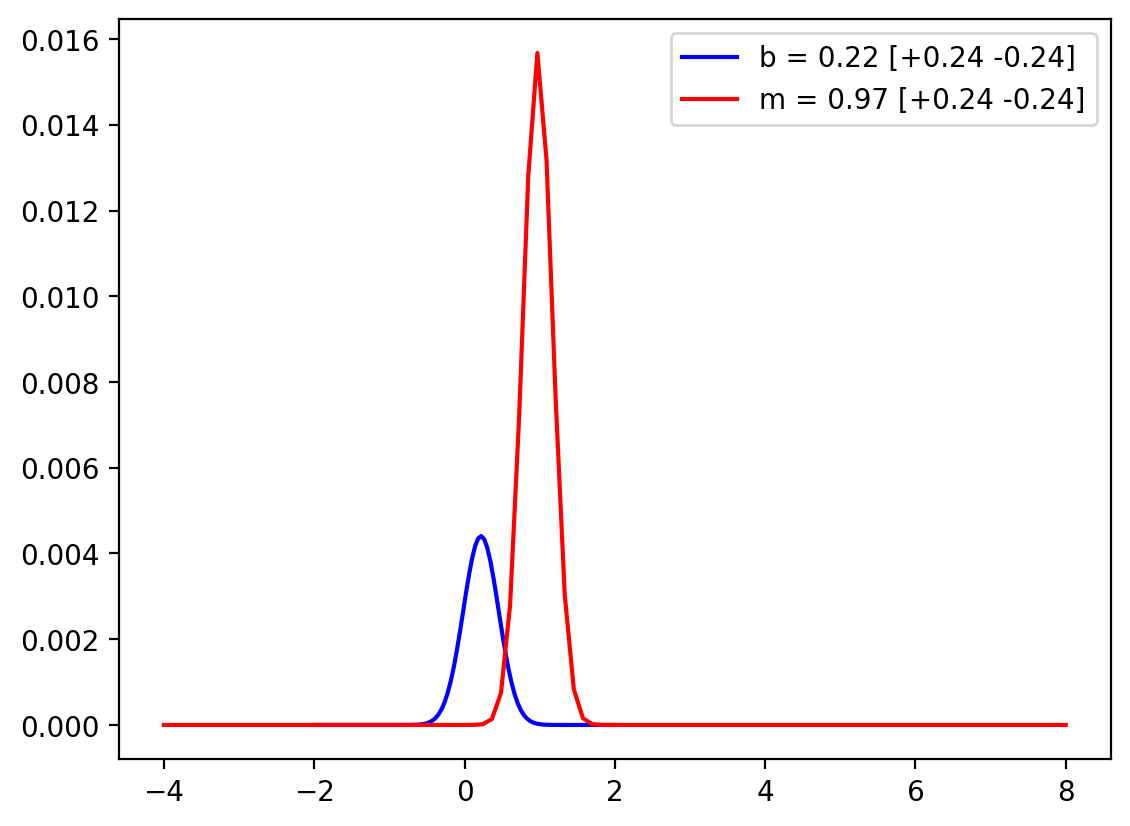

In [22]:
#marginalized constraints 2d case y=b + mx

#marginalize over other params
print(np.shape(post_bm))
bm = np.sum(post_bm, axis=1)
print(np.shape(bm), np.shape(barr))

mu, mx, mn = sig_err(bm, barr)
plt.plot(barr, bm,color='blue', label='b = {:0.2f} [+{:0.2f} -{:0.2f}]'.format(mu, mx, mn))

bm = np.sum(post_bm, axis=0)
print(np.shape(bm), np.shape(marr))
mu, mx, mn = sig_err(bm, marr)

plt.plot(marr, bm, '-', color='red', label='m = {:0.2f} [+{:0.2f} -{:0.2f}]'.format(mu, mx, mn))
plt.legend()

(100, 100, 100)
(100,) (100,)
(100,) (100,)
(100,) (100,)


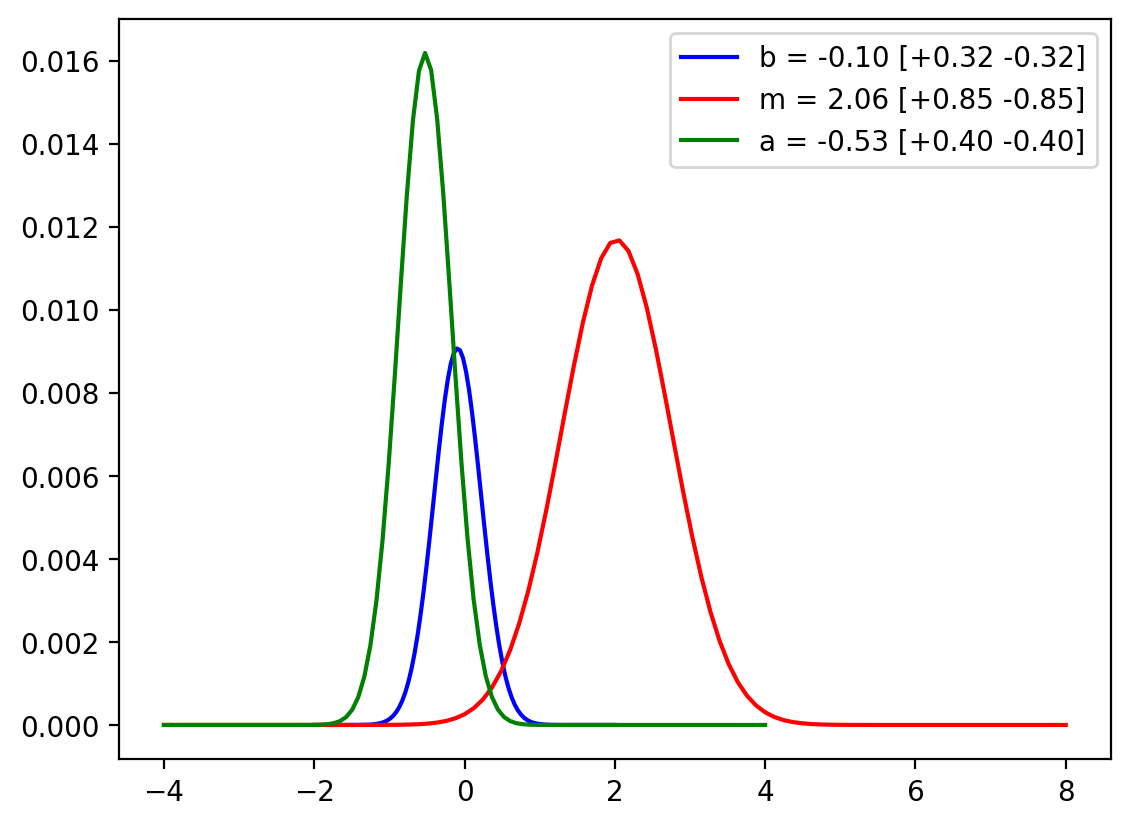

In [23]:
#marginalized constraints 2d case y=b + mx + ax^2

#marginalize over other params (axes)
print(np.shape(post_bma))
bm = np.sum(np.sum(post_bma, axis=1), axis=1)
print(np.shape(bm), np.shape(barr))

mu, mx, mn = sig_err(bm, barr)

plt.plot(barr, bm,color='blue', label='b = {:0.2f} [+{:0.2f} -{:0.2f}]'.format(mu, mx, mn))

bm = np.sum(np.sum(post_bma, axis=0), axis=1)
print(np.shape(bm), np.shape(marr))

mu, mx, mn = sig_err(bm, marr)
plt.plot(marr, bm, color='red', label='m = {:0.2f} [+{:0.2f} -{:0.2f}]'.format(mu, mx, mn))

bm = np.sum(np.sum(post_bma, axis=0), axis=0)
print(np.shape(bm), np.shape(aarr))

mu, mx, mn = sig_err(bm, aarr)
plt.plot(aarr, bm, color='green', label='a = {:0.2f} [+{:0.2f} -{:0.2f}]'.format(mu, mx, mn))
plt.legend()


In [24]:
# d) now get volume elements on the axis grid
db = barr[1]-barr[0]
dbm = (marr[1]-marr[0]) * db
dbma = (aarr[1]-aarr[0]) * dbm


In [37]:

#calculate the probability of the data given the model:
#P (D| M) = integral(posterior, dx)

#use sums for simplicity
P_D_b = np.sum(post_b * db)
P_D_bm = np.sum(post_bm * dbm)
P_D_bma = np.sum(post_bma * dbma)

print ('probability of data given Model1 b, Model2 b+m, Model3 b+m+a (arbitrary normalization)')
print (P_D_b,P_D_bm,P_D_bma)


probability of data given Model1 b, Model2 b+m, Model3 b+m+a (arbitrary normalization)
2.8559264705656275e-08 0.0003147090570625207 7.004533532394938e-05


In [26]:
#what prior probability do we assign to each model?
PMb = 1.0/3.0
PMbm = 1.0/3.0
PMbma = 1.0/3.0

In [36]:
#calculate evidences
sum_PMD = (P_D_b * PMb + P_D_bm * PMbm +  P_D_bma * PMbma )
P_M1_D = P_D_b * PMb / sum_PMD
P_M2_D = P_D_bm * PMbm / sum_PMD
P_M3_D = P_D_bma * PMbma / sum_PMD

print ('Evidence of data given Model1 b, Model2 b+m, Model3 b+m+a')
print (P_M1_D,P_M2_D,P_M3_D)
print ('\n')


#determine ratios between models.
print ('Evidence ratio = model1/model2:  ratio < 1 disfavor model 1. If ratio > 1 disfavor model 2')
print ('ratio of Model b to b+m = {:0.2e}'.format(P_M1_D / P_M2_D))
print ('ratio of Model b to b+m+a = {:0.2e}'.format(P_M1_D / P_M3_D))
print ('ratio of Model b+m to b+m+a = {:0.2e}'.format(P_M2_D / P_M3_D))


Evidence of data given Model1 b, Model2 b+m, Model3 b+m+a
7.422175172549386e-05 0.8178872159279541 0.18203856232032037


Evidence ratio = model1/model2:  ratio < 1 disfavor model 1. If ratio > 1 disfavor model 2
ratio of Model b to b+m = 9.07e-05
ratio of Model b to b+m+a = 4.08e-04
ratio of Model b+m to b+m+a = 4.49e+00


In [68]:
# e) with sigma_y = 1. the data get more noisy, so the errors on the model parameters increase and the evidence ratios
# of the different models become closer to one.

In [69]:
# f) more data points means smaller errors on the model parameters and hence evidence ratios very different from one.